# clean code - open & close principle
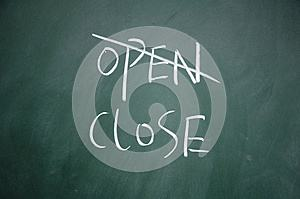
## <center>wang liyao (leo)</center>

## what's open close principle

- 定义：一个软件实体如类、模块和函数应该对扩展开放，对修改关闭。
- Definition: a software entity such as a class, module, and function should be open to extension and closed to modification.

# kill process example

### implement  "kill process" keyword
Users have a requirement to implement a keyword to kill process,  
input arguments is a list of the "process name". 

In [ ]:
import subprocess
def kill_process(*process_list):
    for each_process in process_list:
        ppid = subprocess.check_output("ps -ef |grep {} |grep -v grep |awk -F ' ' '{print $2}'".format(each_process))
        ret = subbprocess.call('sudo kill - 9 {}'.format(ppid))

### "bug" driven keyword need be modified
One day, our user wanted to kill the kibana process with this keyword,  
but found that it didn't work. then we found out that the kibana process  
was not named kibana but node

In [ ]:
import subprocess
def kill_process(*process_list):
    for each_process in process_list:
        if each_p_process == 'kibana':
            each_process = 'node'
        ppid = subprocess.check_output("ps -ef |grep {} |grep -v grep |awk -F ' ' '{print $2}'".format(each_process))
        ret = subbprocess.call('sudo kill - 9 {}'.format(ppid))

### refactor the 'kill process' keyword with open close principle

In [ ]:
import subprocess
class Process(object):
    def __init__(self, name):
        self.process_name = name
    def pid(self):
        ret = subprocess.check_output("ps -ef |grep {} |grep -v grep |awk -F ' ' '{print $2}'".format(self.process_name), shell=True).strip()
        return ret
    def start(self):
        pass
    def stop(self):
        subprocess.check_output('sudo kill -9 {}'.format(self.pid()), shell=True)
class KibanaProcess(Process):
    def __init__(self, name):
        self.process_nme = 'node'
class ProcessFactory(object):
    def get_process_instant(self, name):
        ssh_con_dict = {'kibana': KibanaProcess}
        process_class = ssh_con_dict.get(name, Process)
        return process_class(name)
class ProcessControl(object):
    def __init__(self, process_name_list):
        self.ppid = None
        self.process_name_list = process_name_list
    def stop(self):
        for process_name in self.process_name_list:
            ProcessFactory().get_process_instant(process_name).stop()
def kill_process(*process_list):
    ProcessControl(process_list).stop()          

### add new process - open to extension

In [ ]:
class BtsLogProcess(Process):
    def __init__(self, name):
        self.process_nme = 'syslog.py'

class SiteManagerProcess(Process):
    
    def __init__(self, name):
        self.process_nme = 'java'
# then add the new class in factory
class ProcessFactory(object):
    def get_process_instant(self, name):
        ssh_con_dict = {'kibana': KibanaProcess}
        ssh_con_dict['btslog'] = BtsLogProcess
        ssh_con_dict['SiteManager'] = SiteManagerProcess
        process_class = ssh_con_dict.get(name, Process)
        return process_class(name)


# capture logs example

Suppose we already have capture syslog, infomodel log and aatrace message  
log(every have start and stop * log keywords), and one day user want us to  
implement a new common keyword for capture all the logs

### quick implementation

In [ ]:
# interface.py
def start_capture_common_logs(syslog=True, infomodel=True, aatrace=True, log_save_path="/tmp"):
    start_syslog(log_save_path)
    setup_infomodel(definitions_file_path=log_save_path)
    start_infomodel_logger()
    start_aatrace(log_save_path)

def stop_capture_common_logs():
    stop_syslog()
    stop_infomodel_logger()
    teardown_all_aliases_for_infomodel()
    stop_aatrace() 

### new requirement
1. user want provide the aatrace profile which include the aatrace msg filter.
2. user also want save the different log to different path
3. If one log fails to start, the corresponding stop log is not executed

In [ ]:
# interface.py
def start_capture_common_logs(syslog=True, infomodel=True, aatrace=True,
                              syslog_save_path="/tmp", infomodel_save_path="/tmp", aatrace_save_path="/tmp",
                             aatrace_profile='profile.txt'):
    start_syslog(syslog_save_path)
    setup_infomodel(definitions_file_path=infomodel_save_path)
    start_infomodel_logger()
    start_aatrace(aatrace_save_path, profile=aatrace_profile)

def stop_capture_common_logs():
    try:
        stop_syslog()
    except:
        pass
    try:
        stop_infomodel_logger()
        teardown_all_aliases_for_infomodel()
    except:
        pass
    try:
        stop_aatrace()
    except:
        pass

### robot case example
```robot
***settings***
library    ta_user_log

***test cases***
test_demo
    start_capture_common_logs   syslog=${True}    infomodel=${True}    aatrace=${True}  \
    ...                 syslog_save_path="/tmp/syslog"    infomodel_save_path="/tmp/infomodel" \   
    ...                 aatrace_save_path="/tmp/aatrace"  aatrace_profile="profile.txt"                             
    stop_capture_common_logs
```

### What's the disadvantage about this example?

** 1.Too many parameters and the correspondence between parameters  
can only be matched by name **

** 2.python stop *log function have too much try and except  
waste unnecessary time **

** 3.Adding a new type of log is not convenient,  
and changing the code in one place can cause bugs **

### refactor the capture logs with open close principle

In [ ]:
# interface.py
class user_log_config(object):
    def __init__(self):
        pass
    def create_syslog_object(self, *args, **kwargs):
        syslog_obj = SysLog(*args, **kwargs)
        return syslog_obj
    def create_infomodel_log_object(self, *args, **kwargs):
        infomodel_obj = InfomodelLog(*args, **kwargs)
        return infomodel_obj
    def create_aatrace_log_object(self, *args, **kwargs):
        aatrace_obj = AatraceLog(*args, **kwargs)
        return aatrace_obj
class ta_user_log(user_log_config):
    def __init__(self):
        self.log_obj_list = []
    def start_collect_specific_log(self, *args):
        for logger in args:
            logger.start()
            self.log_obj_list.append(logger)
    def stop_collect_specific_log(self):
        for logger in self.log_obj_list:
            logger.stop()


In [ ]:
# log_imp.py
from abc import abstractmethod
class LogBase(object):
    def __init__(self, *args, **kwargs):
        self.args = args
        self.kwargs = kwargs
    @abstractmethod
    def start(self):
        pass
    @abstractmethod
    def stop(self):
        pass
class SysLog(LogBase):
    def __init__(self, *args, **kwargs):
        super(SysLog, self).__init__(*args, **kwargs)
        self.log_save_path = kwargs.get('log_save_path', '/tmp')
        self.syslogger = ute_syslog()
    def start(self):
        self.syslogger.start_syslog(self.log_save_path)
    def stop(self):
        self.syslogger.stop_syslog()

class InfomodelLog(LogBase):
    def __init__(self, *args, **kwargs):
        super(InfomodelLog, self).__init__(*args, **kwargs)
        self.infomodeler = ute_infomodel()
        self.log_save_path = kwargs.get('log_save_path', '/tmp')
    def start(self):
        self.infomodeler.setup_infomodel(definitions_file_path=self.log_save_path)
        self.infomodeler.start_infomodel_logger(self.log_save_path)
    def stop(self):
        self.infomodeler.stop_infomodel_logger()
        self.infomodeler.teardown_all_aliases_for_infomodel()
class AatraceLog(LogBase):
    def __init__(self, *args, **kwargs):
        super(AatraceLog, self).__init__(*args, **kwargs)
        self.profile=kwagrs.get('profile.txt')
        self.log_save_path = kwargs.get('log_save_path', '/tmp')
        self.aatracelogger = ute_aatrace()
    def start(self):
        self.aatracelogger.start_aatrace(self.log_save_path, profile=self.profile)
    def stop(self):
        self.aatracelogger.stop_aatrace()

### robot case example
```robot
***settings***
library    ta_user_log

***test cases***
test_demo
    ${syslog_obj}=        create_syslog_object    log_save_path="/tmp/syslog/"
    ${infomodel_obj}=     create_infomodel_log_object    log_save_path="/tmp/infomodel/"
    ${aatrace_obj}=       create_aatrace_log_object      log_save_path="/tmp/aatrace/"    profile="profile.txt"
    start_collect_specific_log    ${syslog_obj}    ${infomodel_obj}    ${aatrace_obj}
    stop_collect_specific_log
```